# Homework 5 RF Accuracy Improvement

This assignment is inspired by examples of Shan-Hung Wu from National Tsing Hua University.

Requirement: improve the accuracy per feature of the following code from 0.03 up to at least 0.45 and accuracy should be more than 0.92

Here are three hints:

    You can improve the ratio by picking out or "creating" several features.
    Tune hyperparameters
    The ratio can be improved from 0.03 up to 0.47.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np


# load the breast_cancer dataset
init_data = load_breast_cancer()
(X, y) = load_breast_cancer(return_X_y=True)

print(X.shape)

# TODO Select some features (X), hint: based on the connections with
# our Y (importance? correlation?)
# TODO need 5 fold cross validation
# TODO Tune parameters for RandomForestClassifier
# TODO Calculate Average accuracy score
# TODO Calculate Average (accuracy score/number of features)

(569, 30)


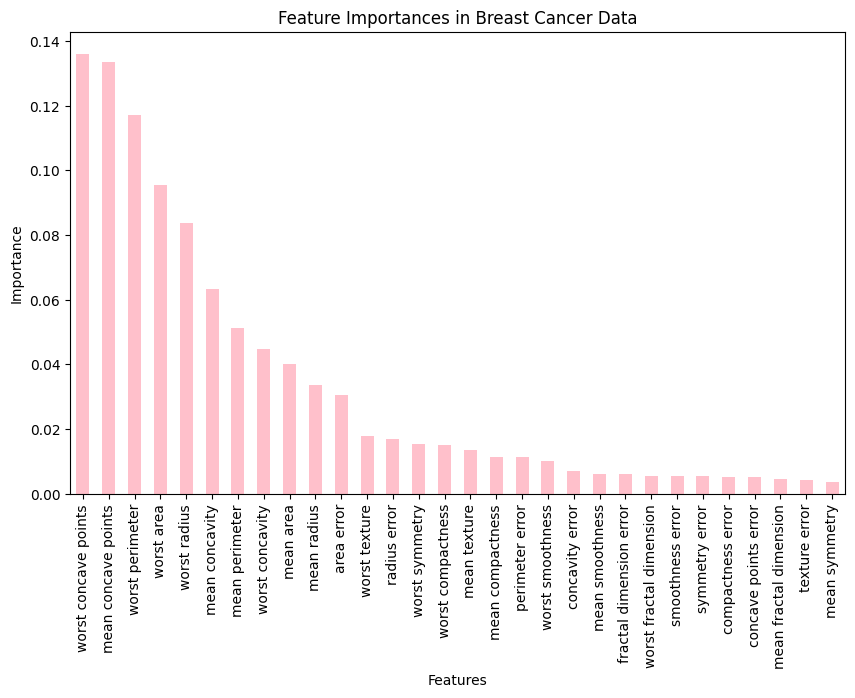

In [16]:
#Build model and Examining Features of High Importance
import matplotlib.pyplot as plt
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.33, random_state=42)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
feature_importances = model.feature_importances_
feature_imp = pd.Series(feature_importances, index=init_data.feature_names)
feature_imp = feature_imp.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_imp.plot(kind='bar', color='pink')
plt.title('Feature Importances in Breast Cancer Data')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [9]:
#Selecting Features of High Importance
feature_names = np.array(init_data.feature_names)
sorted_feature_names = feature_names[np.argsort(feature_importances)[::-1]]
selected_features = sorted_feature_names[:15]


selected_indices = [np.where(sorted_feature_names == feature)[0][0] for feature in selected_features]

X_train_selected = Xtrain[:, selected_indices]
X_test_selected = Xtest[:, selected_indices]
model.fit(X_train_selected, ytrain)
print("Selected Features:", selected_features)

Selected Features: ['mean concave points' 'worst concave points' 'worst perimeter'
 'worst area' 'worst radius' 'mean concavity' 'worst concavity'
 'mean perimeter' 'mean area' 'area error' 'mean radius'
 'worst compactness' 'worst texture' 'radius error' 'mean texture']


In [10]:
# 5-fold Cross Validation

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Score:", cv_scores.mean())

Cross-Validation Score: 0.9613569321533924


In [11]:
# Parameter Tuning 

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(50, 1000),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train_selected, ytrain)
best_params = random_search.best_params_
print("Best Parameters:", best_params)
best_rf_classifier = random_search.best_estimator_
model = RandomForestClassifier(**best_params, random_state=42)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 108}


                      Accuracy
mean concave points   0.808511
worst concave points   0.62234
worst perimeter       0.819149
worst area            0.819149
worst radius          0.648936
mean concavity        0.765957
worst concavity       0.840426
mean perimeter         0.87234
mean area             0.595745
area error            0.537234
mean radius           0.755319
worst compactness     0.558511
worst texture         0.771277
radius error          0.840426
mean texture          0.505319


<Figure size 1200x600 with 0 Axes>

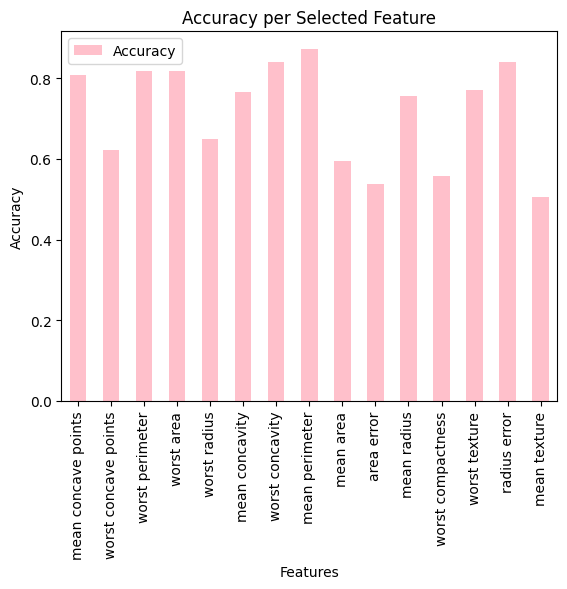

Mean Accuracy across Features: 0.7173758865248228
Cross-Validation Score: 0.9613724576929048


In [17]:
# Accuracy per Feature and Mean Accuracy

feature_accuracy = pd.DataFrame(index=selected_features, columns=['Accuracy'])
for feature in selected_indices:
    X_train_feature = X_train_selected[:, feature].reshape(-1, 1)
    X_test_feature = X_test_selected[:, feature].reshape(-1, 1)
    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train_feature, ytrain)
    y_pred_feature = model.predict(X_test_feature)
    acc_feature = accuracy_score(ytest, y_pred_feature)
    feature_accuracy.loc[selected_features[feature], 'Accuracy'] = acc_feature


print(feature_accuracy)

mean_accuracy = feature_accuracy['Accuracy'].mean()
plt.figure(figsize=(12, 6))
feature_accuracy.plot(kind='bar', color='pink')
plt.title('Accuracy per Selected Feature')
plt.xlabel('Features')
plt.ylabel('Accuracy')
plt.show()
print("Mean Accuracy across Features:", mean_accuracy)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Score:", cv_scores.mean())